In [1]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

TRAIN_PATH = 'C:\\AI Learning\\Analytics Vidhya\\Twitter Sentiment'

train_data = pd.read_csv(os.path.join(TRAIN_PATH,"train_2kmZucJ.csv"))
test_data = pd.read_csv(os.path.join(TRAIN_PATH,"test_oJQbWVk.csv"))

#train_data.hist(bins=50, figsize=(20,15))
#train_data.drop(['id', 'lang', 'original_author','retweet_count'], axis=1, inplace=True)
#test_data.drop(['id', 'lang', 'original_author','retweet_count'], axis=1, inplace=True)
print(train_data.describe())
print(test_data.describe())
#ps = nltk.PorterStemmer()
#new_text = "I would really like to have a black color Ather with red coloured rim (rather than yellow) for collectors edition ! Would be really damn nice with that find and roses theme " #train_data["original_text"][11]
#new_text = re.sub(r'\W+', ' ', new_text, flags=re.M)
#words = word_tokenize(new_text)
#for w in words:
#    print(ps.stem(w))
#tokens = word_tokenize(new_text)
#tokens = [w.lower() for w in tokens]

# remove all tokens that are not alphabetic
#words = [word for word in tokens if word.isalpha()]

#stop_words = set(stopwords.words('english'))
#words = [w for w in words if not w in stop_words]
#words = [ps.stem(w) for w in words]
#print(words[:100])

#sid = SentimentIntensityAnalyzer()
#scores = sid.polarity_scores(new_text)

#print(scores)
#for key in sorted(scores):
#        print('{0}: {1}, '.format(key, scores[key]), end='')



                id        label
count  7920.000000  7920.000000
mean   3960.500000     0.255808
std    2286.451399     0.436342
min       1.000000     0.000000
25%    1980.750000     0.000000
50%    3960.500000     0.000000
75%    5940.250000     1.000000
max    7920.000000     1.000000
                id
count  1953.000000
mean   8897.000000
std     563.926857
min    7921.000000
25%    8409.000000
50%    8897.000000
75%    9385.000000
max    9873.000000


In [2]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = []
        count_mentions = []
        count_hashtags = []
        count_capital_words = []
        count_excl_quest_marks = []
        count_urls = []
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = []
        #print(X.head())
        for x in X:
            count_words.append(self.count_regex(r'\w+', x))
            count_mentions.append(self.count_regex(r'@\w+', x))
            count_hashtags.append(self.count_regex(r'#\w+', x))
            count_capital_words.append(self.count_regex(r'\b[A-Z]{2,}\b', x))
            count_excl_quest_marks.append(self.count_regex(r'!|\?', x))
            count_urls.append(self.count_regex(r'http.?://[^\s]+[\s]?', x))
            # We will replace the emoji symbols with a description, which makes using a regex for counting easier
            # Moreover, it will result in having more words in the tweet
            count_emojis.append(self.count_regex(r':[a-z_&]+:', emoji.demojize(x)))
        
#        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
#        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
#        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
#        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
#        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
#        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
#        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        return df


In [3]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = nltk.PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = []
        for x in X:
            x = re.sub(r'@\w+', '', x) #remove_mentions
            x = re.sub(r'http.?://[^\s]+[\s]?', '', x) #remove_urls
            x = x.replace('_','') #emoji_oneword
            
            # Every punctuation symbol will be replaced by a space
            punct = string.punctuation
            trantab = str.maketrans(punct, len(punct)*' ')  
            x = x.translate(trantab)
            
            x = re.sub('\d+', '', x) #remove_digits
            
            x = x.lower() #to_lower
            
            #remove_stopwords
            stopwords_list = stopwords.words('english')
            whitelist = ["n't", "not", "no"]
            words = x.split() 
            clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
            x = " ".join(clean_words) 
            
            #Stem
            porter = nltk.PorterStemmer()
            words = x.split() 
            stemmed_words = [porter.stem(word) for word in words]
            x = " ".join(stemmed_words)
            
            clean_X.append(x)
        #clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.remove_punctuation).apply(self.emoji_oneword).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return np.array(clean_X)

In [4]:
tc = TextCounts()
train_data_eda = tc.fit_transform(train_data.original_text)
train_data_eda['sentiment_class'] = train_data.sentiment_class

Descriptive stats for count_hashtags
------------------------------------
                  count      mean       std  min  25%  50%  75%   max
sentiment_class                                                      
-1                769.0  2.286086  2.967941  0.0  0.0  1.0  4.0  21.0
 0               1701.0  2.407407  3.090466  0.0  0.0  1.0  3.0  28.0
 1                765.0  2.287582  3.092960  0.0  0.0  1.0  3.0  27.0


C:\Users\Gandharv\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


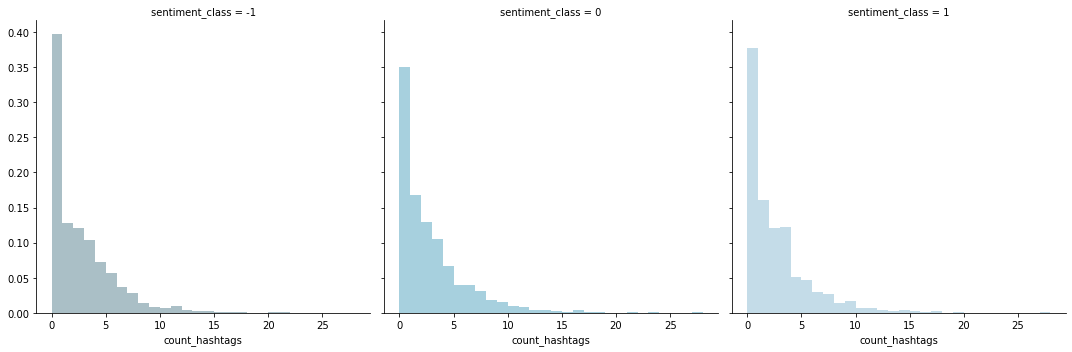

In [8]:
col = "count_hashtags"
print('Descriptive stats for {}'.format(col))
print('-'*(len(col)+22))
print(train_data_eda.groupby('sentiment_class')[col].describe())
bins = np.arange(train_data_eda[col].min(), train_data_eda[col].max() + 1)
g = sns.FacetGrid(train_data_eda, col='sentiment_class', size=5, hue='sentiment_class', palette="PuBuGn_d")
g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
plt.show()

In [5]:
import collections
from sklearn.feature_extraction.text import HashingVectorizer

ct = CleanText()
train_data_clean = ct.fit_transform(train_data.original_text)

hv = HashingVectorizer(n_features=500)
bow = hv.transform(train_data_clean)
print(bow.shape)
#cv = CountVectorizer()
#bow = cv.fit_transform(train_data_clean)
#print(cv.vocabulary_)

#word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
#word_counter = collections.Counter(word_freq)
#word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

#fig, ax = plt.subplots(figsize=(12, 10))
#bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
#plt.show();
#if not KAGGLE_ENV: bar_freq_word.get_figure().savefig('../output/bar_freq_word.png')

(3235, 500)


In [6]:
train_data_eda["clean_text"] = train_data_clean
train_data_eda.columns.tolist()


['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'sentiment_class',
 'clean_text']

In [4]:
text_count_pipeline = Pipeline([
    ("textcounts", TextCounts())
])

text_preprocess_pipeline = Pipeline([
    ("cleantext", CleanText()),
    ("vect", CountVectorizer(max_features=4096))
])

full_pipeline = FeatureUnion(transformer_list=[
        ("text_count_pipeline", text_count_pipeline),
        ("text_preprocess_pipeline", text_preprocess_pipeline),
    ])

train_rows = len(train_data["tweet"])
test_rows = len(test_data["tweet"])

print(train_rows)
print(test_rows)
combined = pd.concat([train_data, test_data], axis = 0)
combined_rows = len(combined["tweet"])

print(combined_rows)

#train_data_text = train_data.original_text

train_data_labels = train_data.label
combined_data_transformed = full_pipeline.fit_transform(combined.tweet)

train_data_transformed = combined_data_transformed[0:train_rows]
print(combined_data_transformed.shape)
print(train_data_transformed.shape)
#train_data_transformed["sentiment_class"] = train_data["sentiment_class"]
#train_data.head()


7920
1953
9873


C:\Users\Gandharv\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(9873, 4103)
(7920, 4103)


In [12]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

logreg = LogisticRegression()
logreg.fit(train_data_transformed, train_data_labels)

xgb_model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective="binary:logistic", random_state=42)

param_grid = [{
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }]


clf = GridSearchCV(xgb_model, param_grid, n_jobs=5, scoring='f1')

clf.fit(train_data_transformed, train_data_labels)



C:\Users\Gandharv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gandharv\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=5,
             param_grid=[{'colsample_bytree': [0.6, 0.8, 1

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


y_pred = logreg.predict(train_data_transformed)
y_pred_xgb = clf.predict(train_data_transformed)

print(f1_score(train_data_labels, y_pred, average = 'weighted'))
print(f1_score(train_data_labels, y_pred_xgb, average = 'weighted'))

0.9536974129743393
0.916602404122653


In [15]:
test_data_transformed = combined_data_transformed[train_rows:]
#print(test_data_transformed.shape)
test_data_pred = clf.predict(test_data_transformed)


In [16]:
test_data["label"] = test_data_pred
test_data

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1
5,7926,0
6,7927,1
7,7928,0
8,7929,1
9,7930,0


In [18]:
#test_data.drop(["tweet"], axis = 1, inplace = True)
test_data.to_csv(os.path.join(TRAIN_PATH,"testClassified.csv"))

KeyError: "['original_text' 'lang' 'retweet_count' 'original_author'] not found in axis"

In [43]:
test_data.to_csv(os.path.join(TRAIN_PATH,"testClassifiedSubmission.csv"), encoding="utf-8")

KeyError: 0